In [1]:
import qdmpy
import qdmpy.pl
import qdmpy.plot
import qdmpy.field
import qdmpy.source

import matplotlib
import numpy as np

In [2]:
# '%matplotlib widget' allows interactive plots in jupyterlab
# use ''%matplotlib inline' to allow export to pdf
# %matplotlib widget

### Load raw data

In [3]:
options_dict = {
    "base_dir": "/home/samsc/ResearchData/test_images/CCPS_test_images/",
    "filepath": "ODMR - Pulsed_56",
    "custom_output_dir_suffix": "_{ROI}_bin_{total_bin}",
    
    "additional_bins": 8,
    
    "polygon_nodes_path": "/home/samsc/ResearchData/test_images/CCPS_test_images/polygon_56.json",
    "annotate_polygons": True,
    "bfield_bground_method": "interpolate",
    "bfield_bground_params": {
        "interp_method": "linear",
        "sigma": 3
    },
    "bnv_bground_method": "interpolate",
    "bnv_bground_params": {
        "interp_method": "linear",
        "sigma": 3
    },
    
    "source_bground_method": "interpolate",
    "source_bground_params": {
        "interp_method": "linear",
        "sigma": 2
    },
    "exp_reference_type": "pre_gslac",
    
    "system_name": "Cryo_Widefield",

    "ROI": "Full", 
    "ROI_start": [20, 20],
    "ROI_end": [110,130],
    
    "AOI_1_start": [30, 40],
    "AOI_1_end": [40, 45], 
    "AOI_2_start": [20, 20],
    "AOI_2_end": [24, 24], 
    "AOI_3_start": [30, 20],
    "AOI_3_end": [32, 24], 
    "single_pixel_check": [90, 150],
    
    "fit_backend": "scipyfit",
    "fit_backend_comparison": ["scipyfit"],
    "fit_pl_pixels": True, 
    "force_fit": True, 
    
    "use_ROI_avg_fit_res_for_all_pixels": True,
    
    "scipyfit_sub_threads": 2, 

    "fit_functions":  {"linear": 1, "lorentzian": 1},

    "pos_guess": [2743,0],
    "pos_range": 25,

    "amp_guess": -0.008,
    "amp_bounds": [-0.300, -0.000003],
    
    "fwhm_guess": 9,
    "fwhm_bounds": [1, 40],
    
    "c_guess": 1,
    "c_bounds": [0.8, 1.2],

    "m_guess": 0,
    "m_bounds": [-1e-4, 1e-4],
    
    "save_fig_type": "pdf",
    
    "freqs_to_use": [1, 0, 0, 0, 0, 0, 0, 0],
    "diamond_ori": "<100>_<100>", # HPHT
    
    "auto_read_bias": True,
    "bias_mag": 50,
    "bias_theta": 45,
    "bias_phi": 125, # 45
    "NVs_above_sample": True,
    
    "plot_bnv_flip_with_bias_mag": True,
    
    "calc_field_pixels": True,
    "force_field_calc": True,
    
    "colormap_range_dicts": {
        "param_images": {
            "type": "percentile",
            "values": [2, 98],
            "auto_sym_zero": False
        },
        "residual_images": {
            "type": "percentile",
            "values": [2, 98],
        },
        "sigma_images": {
            "type": "percentile",
            "values": [2, 98],
        },
        "bnv_images": {
            "type": "percentile",
            "values": [2, 98],
        },
        "bfield_images": {
            "type": "percentile",
            "values": [2, 98],
        },
        "magnetization_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "dshift_images": {
            "type": "percentile",
            "values": [2, 98],
        }
    },
        
    "standoff": 300e-9,
    
    "source_type": "magnetization",
    "magnetization_angle": 45,
    "in_plane_mag_norm_number_pixels": 10
}
# if you want to use a reference experiment 
ref_options_dir = "/home/samsc/ResearchData/test_images/CCPS_test_images/ODMR - Pulsed_83_Full_bin_16"

In [4]:
options, ref_options = qdmpy.initialize(
    options_dict=options_dict,
    ref_options_dir=ref_options_dir,
    set_mpl_rcparams=True
)

### Load data

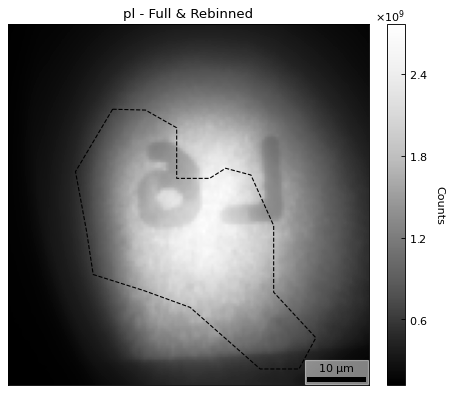

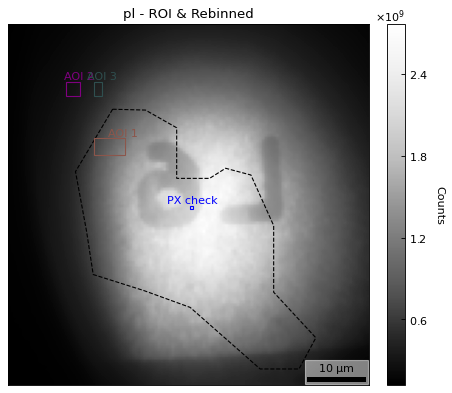

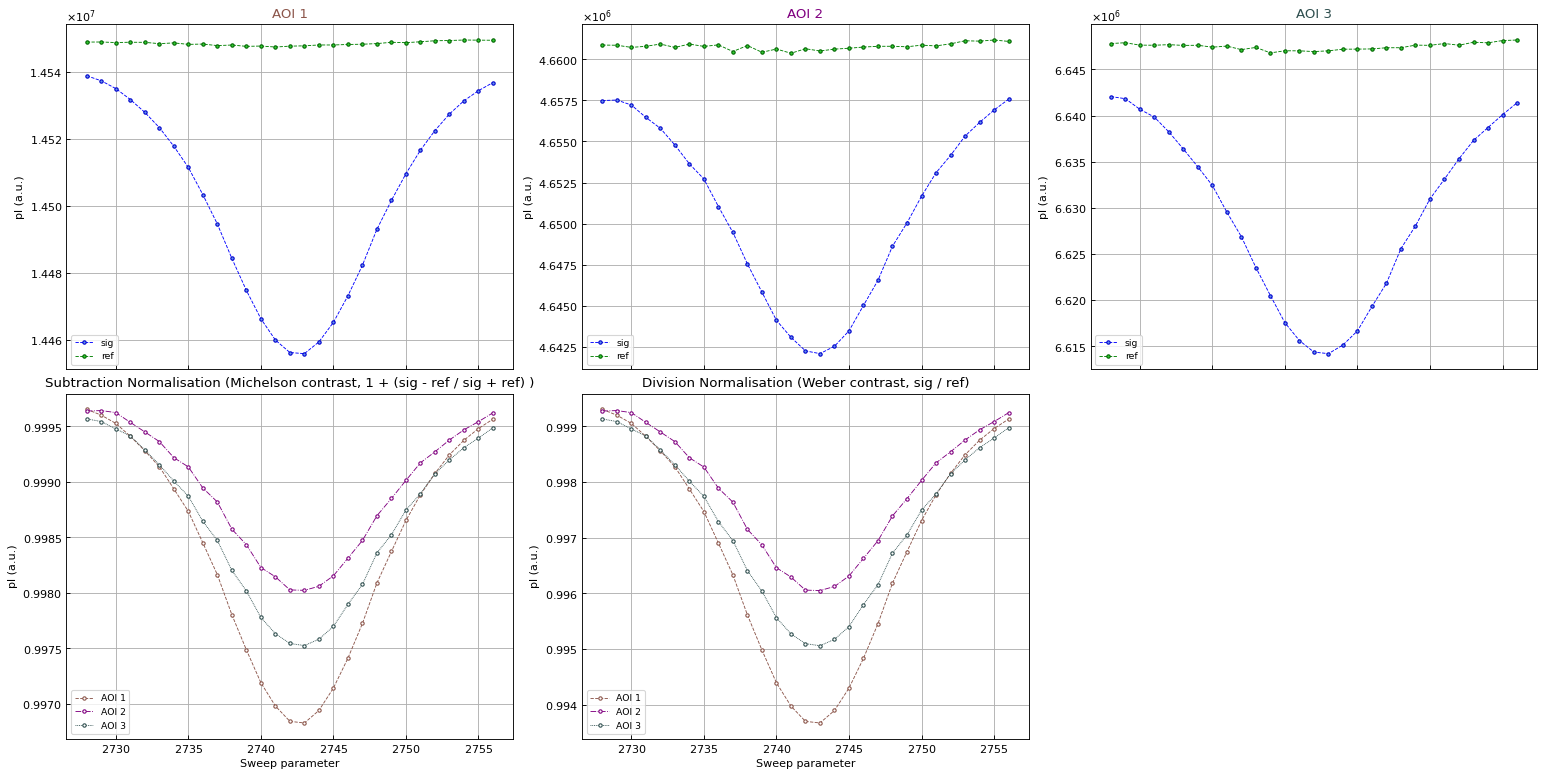

In [6]:
image, prelim_sweep_list = qdmpy.pl.load_image_and_sweep(options)
PL_image, PL_image_ROI, sig, ref, sig_norm, single_pixel_pl, sweep_list, ROI = qdmpy.pl.reshape_dataset(
        options, image, prelim_sweep_list
    )
ROI_PL_fig = qdmpy.plot.roi_pl_image(options, PL_image)

AOI_PL_fig = qdmpy.plot.aoi_pl_image(options, PL_image_ROI)

AOI_spectra_fig = qdmpy.plot.aoi_spectra(options, sig, ref, sweep_list)

qdmpy.pl.save_pl_data(options, PL_image, PL_image_ROI)

### Fit AOI, ROI averages, single pixel

/home/samsc/src/qs/qdmpy_proj/qdmpy_git/src/qdmpy/pl/scipyfit.py:35: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # auto detects jupyter


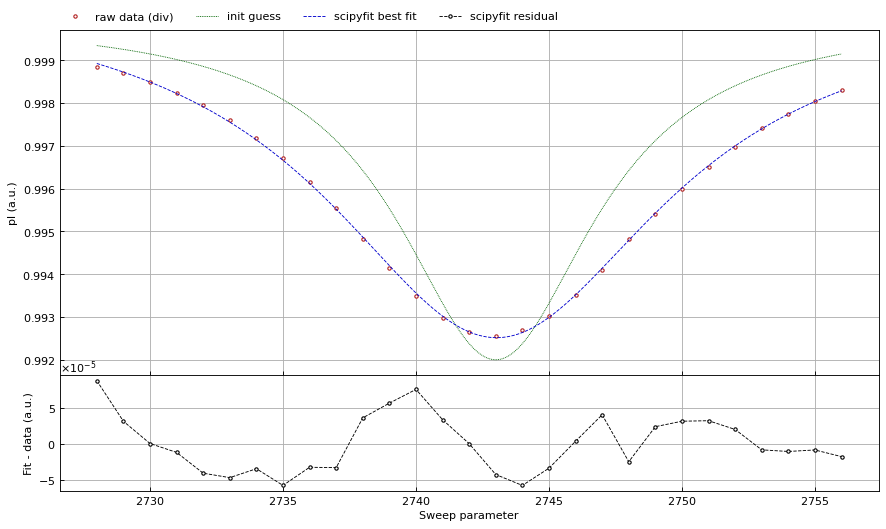

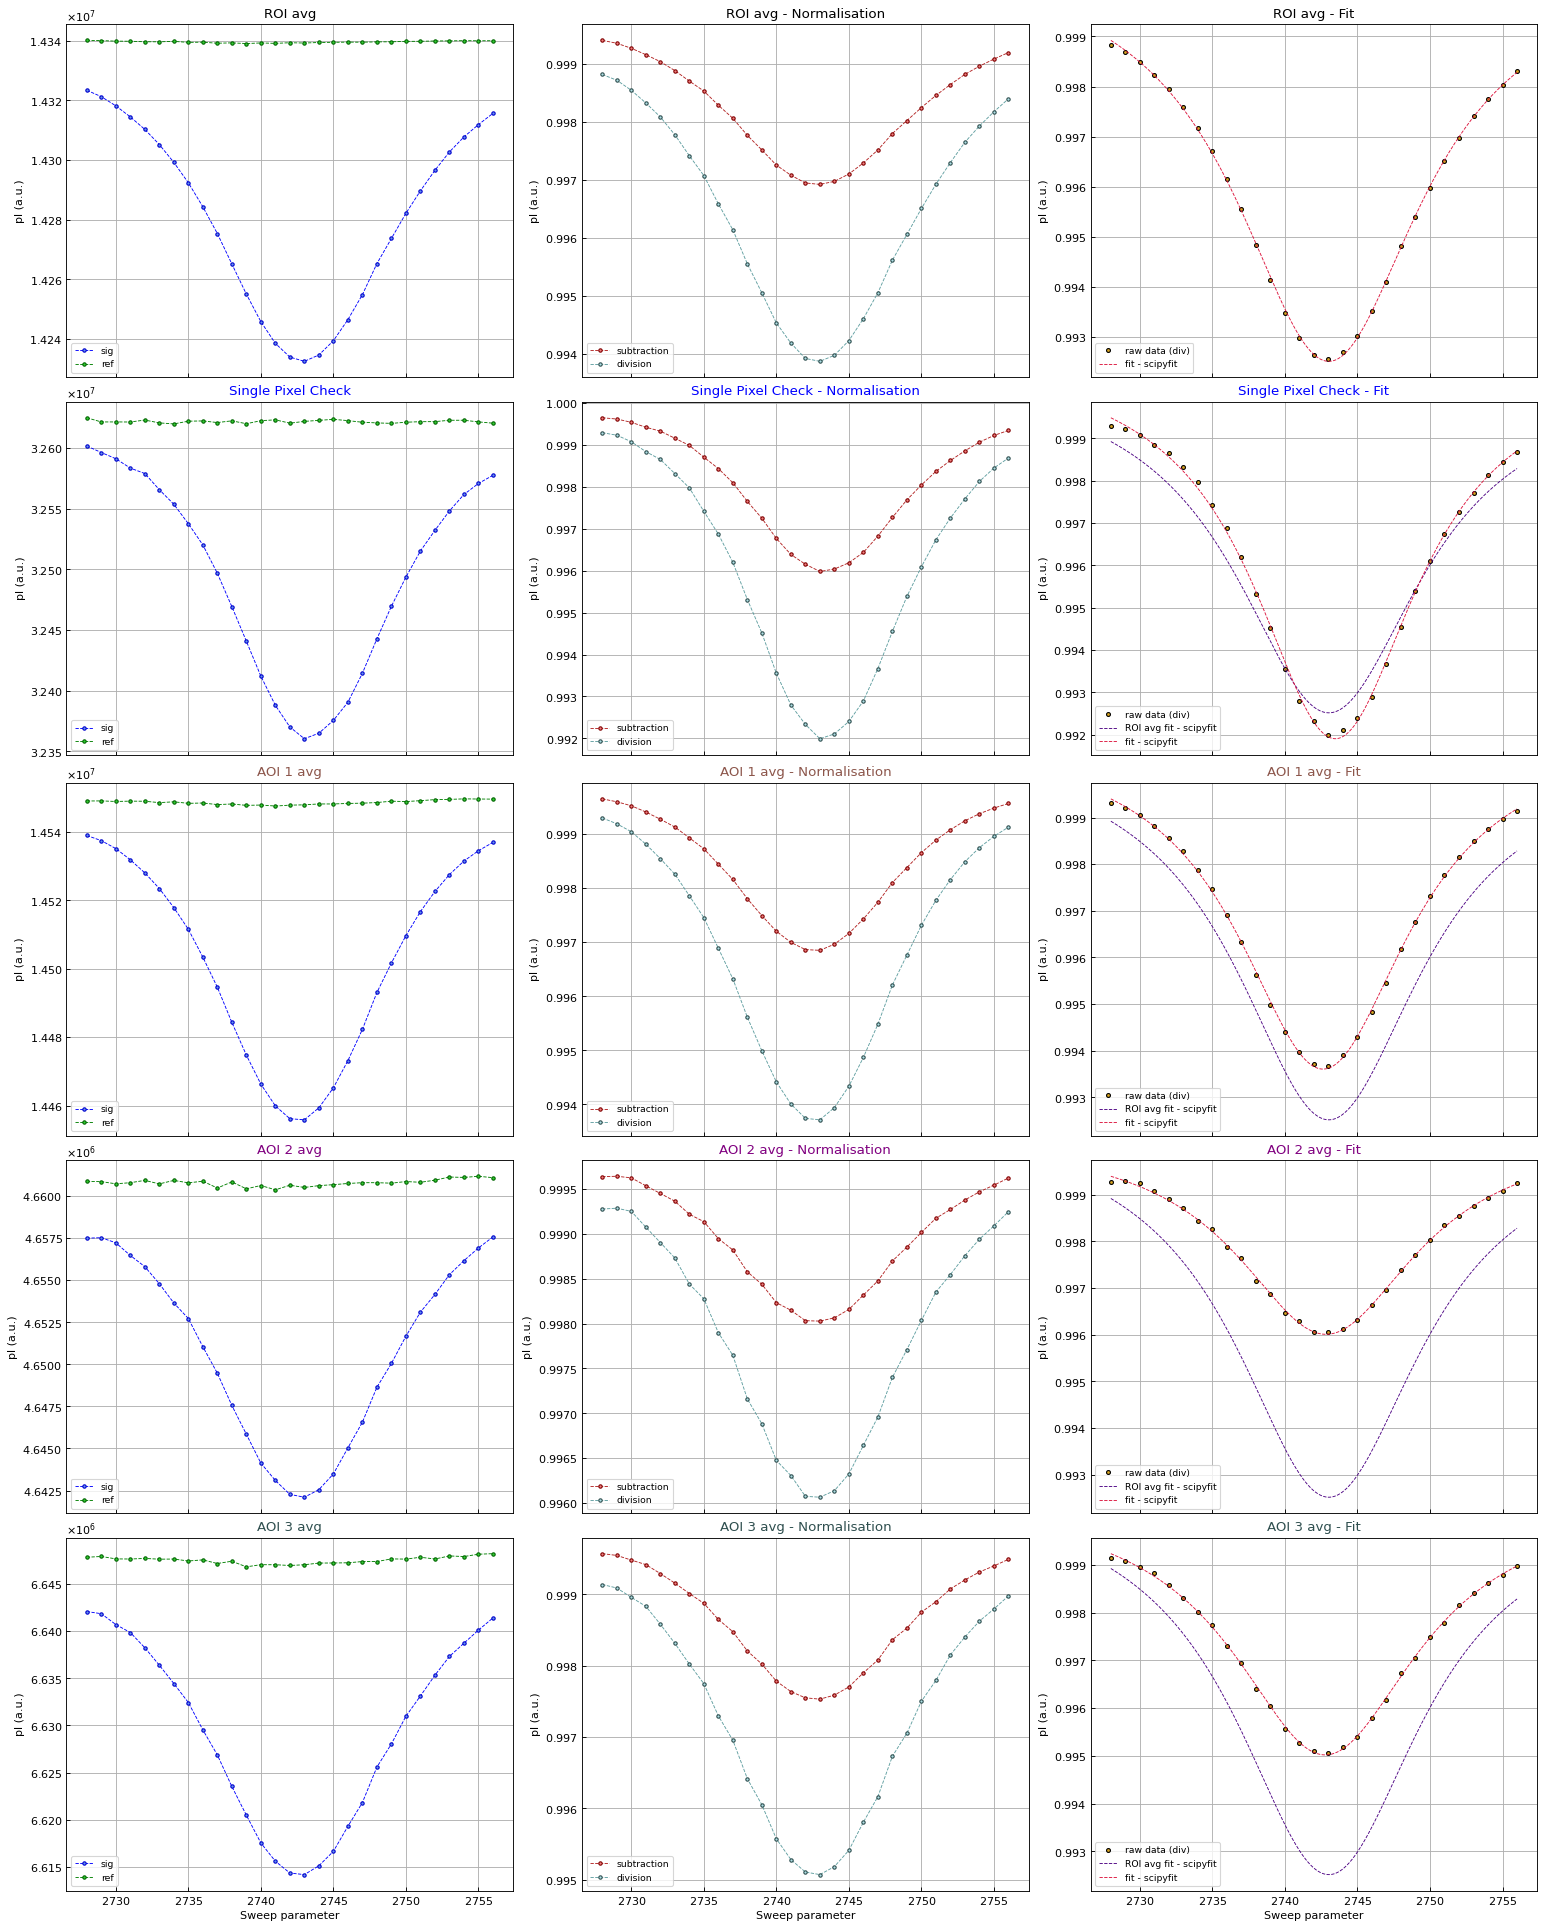

In [7]:
fit_model = qdmpy.pl.define_fit_model(options)
backend_ROI_results_lst = qdmpy.pl.fit_roi_avg_pl(options, sig, ref, sweep_list, fit_model)
ROI_fit_fig = qdmpy.plot.roi_avg_fits(options, backend_ROI_results_lst)

fit_result_collection_lst = qdmpy.pl.fit_aois_pl(options, sig, ref, single_pixel_pl, sweep_list, fit_model, backend_ROI_results_lst)
AOI_fit_fig = qdmpy.plot.aoi_spectra_fit(options, sig, ref, sweep_list, fit_result_collection_lst, fit_model)

In [8]:
### Fit pixels

In [9]:
wanted_roi_result = next(
    filter(
        lambda result: result.fit_backend == options["fit_backend"], backend_ROI_results_lst
    )
) # ROI fit result for chosen fit backend
pixel_fit_params, sigmas = qdmpy.pl.get_pl_fit_result(options, sig_norm, sweep_list, fit_model, wanted_roi_result)

qdmpy.pl.save_pl_fit_results(options, pixel_fit_params)
qdmpy.pl.save_pl_fit_sigmas(options, sigmas)

  0%|          | 0/16384 [00:00<?, ? PX/s]

In [10]:
ref_fit_params, ref_sigmas = qdmpy.pl.load_ref_exp_pl_fit_results(ref_options)

/home/samsc/src/qs/qdmpy_proj/qdmpy_git/src/qdmpy/shared/misc.py:17: QDMPYWarning: Didn't find reference experiment fit results? Reason: couldn't find prev pixel results: couldn't find previous param: c_0
  warnings.warn(msg, QDMPYWarning)


### Plot (fit) parameters

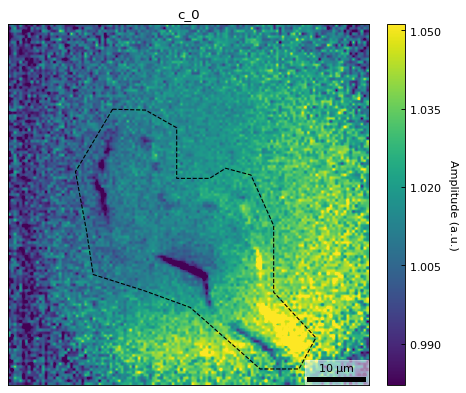

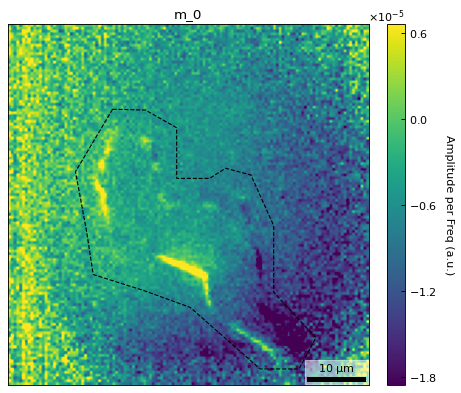

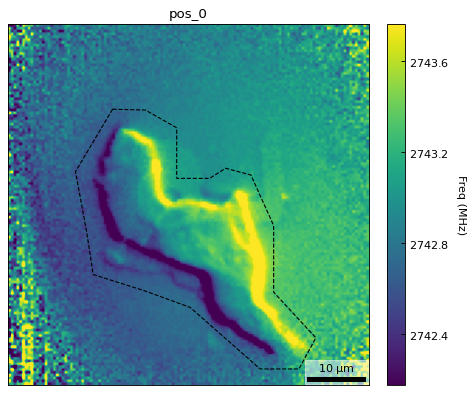

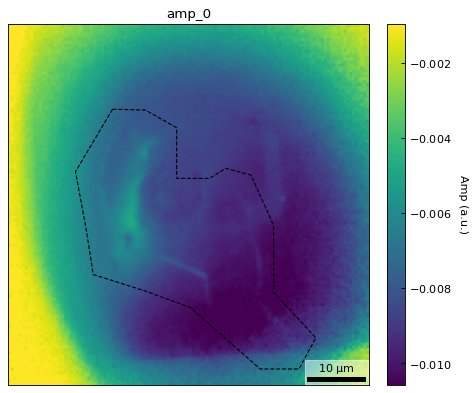

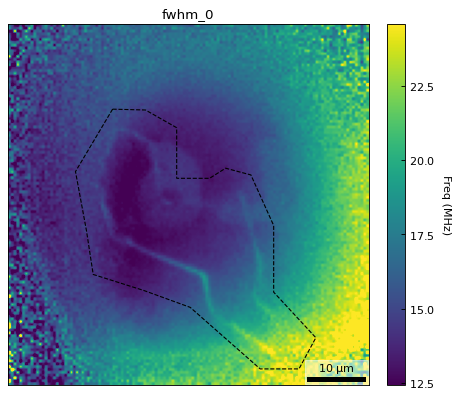

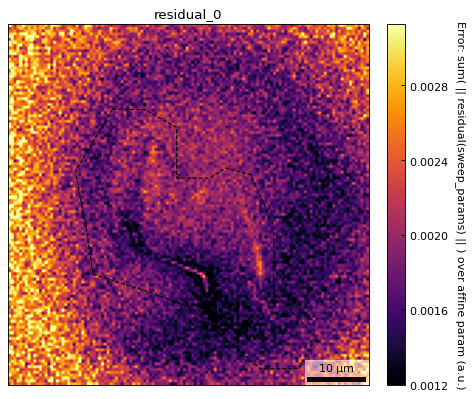

In [11]:
c_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "c")
m_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "m")
pos_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "pos")
amp_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "amp")
fwhm_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "fwhm")
residual_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "residual")

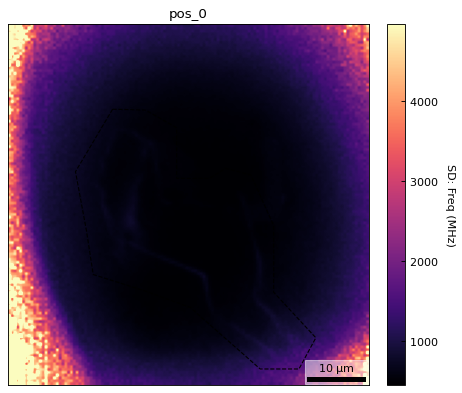

In [12]:
pos_sigma_plot = qdmpy.plot.pl_param_images(options, fit_model, sigmas, "pos", errorplot=True)

### Initial guess and fit vs data (flattened)

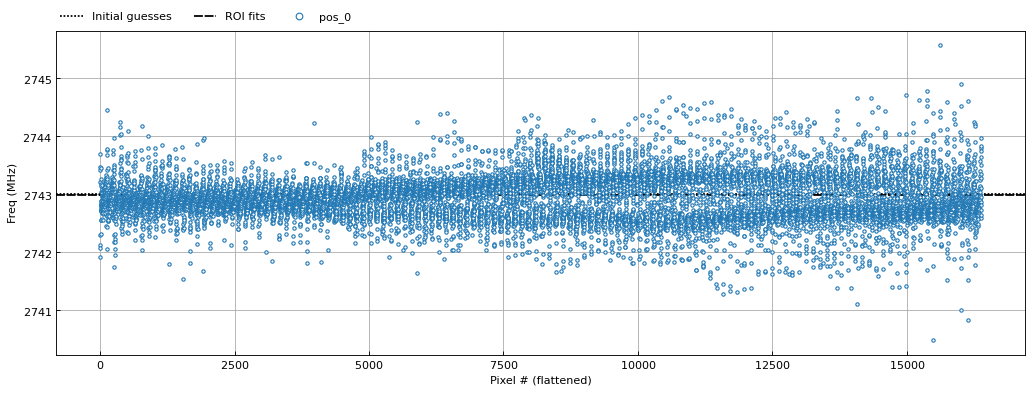

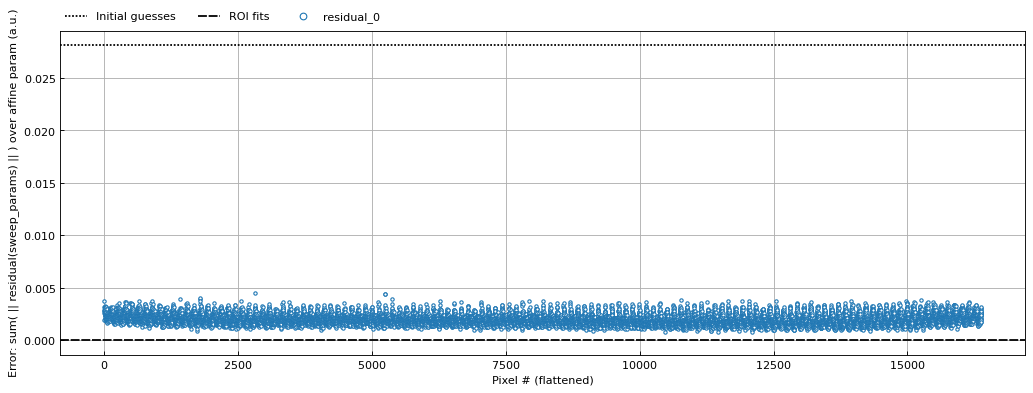

In [13]:
flat_pos_fig = qdmpy.plot.pl_params_flattened(options, fit_model, pixel_fit_params, wanted_roi_result, "pos", sigmas=sigmas, plot_bounds=False, plot_sigmas=False, errorevery=1000)
flat_resid_fig = qdmpy.plot.pl_params_flattened(options, fit_model, pixel_fit_params, wanted_roi_result, "residual", sigmas=sigmas)

### Field retrieval

In [14]:
field_res = qdmpy.field.odmr_field_retrieval(options, pixel_fit_params, ref_fit_params)
(sig_bnvs, ref_bnvs, bnvs), (sig_dshifts, ref_dshifts), (sig_params, ref_params, field_params), (sig_field_sigmas, ref_field_sigmas, field_sigmas) = field_res
qdmpy.field.save_field_calcs(options, *field_res)

RuntimeError: with exp_reference_type = 'pre_gslac' you must define a reference.

In [ ]:
bnv_sig_plot = qdmpy.plot.bnvs_and_dshifts(options, "sig", sig_bnvs, sig_dshifts)
bnv_ref_plot = qdmpy.plot.bnvs_and_dshifts(options, "ref", ref_bnvs, ref_dshifts)
bnvs_plot = qdmpy.plot.bnvs_and_dshifts(options, "sig_sub_ref", bnvs, [])

In [ ]:
bfield_sig_plot = qdmpy.plot.bfield(options, "sig", sig_params)
bfield_ref_plot = qdmpy.plot.bfield(options, "ref", ref_params)
bfield_plot = qdmpy.plot.bfield(options, "sig_sub_ref", field_params)
bfield_bground_plot = qdmpy.plot.bfield(options, "bground", field_params)

In [ ]:
D_sig_plot = qdmpy.plot.dshift_fit(options, "sig", sig_params)
D_ref_plot = qdmpy.plot.dshift_fit(options, "ref", ref_params)

In [ ]:
# Bx_fit_flat_plot = qdmpy.plot.field_param_flattened(options, "sig", "Bx", sig_params, sigmas=sig_field_sigmas, y_label="B (G)", errorevery=1000, plot_guess=False)

In [ ]:
bconsist_plot = qdmpy.plot.bfield_consistency(options, "sig_sub_ref", field_params)

In [ ]:
source_params = qdmpy.source.odmr_source_retrieval(options, bnvs, field_params)
qdmpy.source.save_source_params(options, source_params)

In [ ]:
mag_plot = qdmpy.plot.magnetization(options, source_params, plot_bgrounds=True)

In [ ]:
# qdmpy.field..add_bfield_proj_bias(options, field_params)
qdmpy.field.add_bfield_theta_phi(options, field_params, 90, 45)
btp_plot = qdmpy.plot.bfield_theta_phi(options, "sig_sub_ref", field_params)

### Save and (optionally) view options dict

In [ ]:
qdmpy.save_options(options)
# import qdmpy.shared.json2dict; print(qdmpy.shared.json2dict.dict_to_json_str(options))

## 